## In this notebook we try to see if we can automatically align our photos and merge them into a good looking wobble-gif

* We try aligning the photos by looking at the differences in pixel intensity.
* We try adjusting the colors so that each color is eaqually present on all photos.

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as pyplot

%matplotlib inline

In [2]:
dir_path = '/Users/elgehelge/Downloads/OUTPUT/captured_raw/'
img_base_name = '2018-07-24T13:55:47.373006' #'2018-07-24T12:58:25.948957'
img_names = [img_base_name + '_' + str(i) for i in range(1, 5)]

In [3]:
imgs = [imageio.imread(dir_path + name) for name in img_names]

### Positional alignment

This is what two of the photos looks like as gray scale:

In [4]:
gray_imgs = [img.mean(axis=-1).astype(int) for img in imgs]

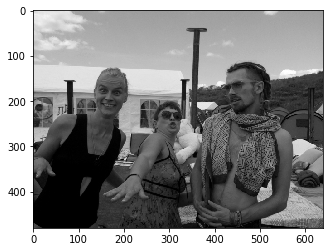

In [5]:
pyplot.imshow(gray_imgs[0], cmap=pyplot.cm.gray)

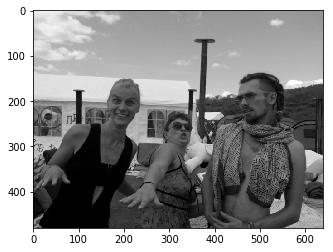

In [6]:
pyplot.imshow(gray_imgs[1], cmap=pyplot.cm.gray)

This is the gray scale intensity difference per pixel:

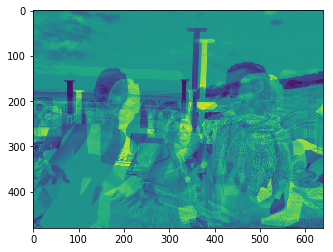

In [7]:
pyplot.imshow(gray_imgs[0] - gray_imgs[1])

Let's summarize that by the mean of the absolute pixel differences:

In [8]:
def mean_pixel_diff(img1, img2):
    return np.abs(img1 - img2).mean()

In [9]:
mean_pixel_diff(gray_imgs[0], gray_imgs[1])

36.863707682291668

And now, let's try shifting the images to a better position and calculate the mean pixel difference again:

In [10]:
def crop(img, left, top, right, bottom):
    height = img.shape[0]
    width = img.shape[1]
    return img[top:height-bottom, left:width-right]

def shift(img1, img2, x, y):
    left, right = (abs(x), 0) if x < 0 else (0, x)
    top, bottom = (abs(y), 0) if y < 0 else (0, y)
    img1_shifted = crop(img1, left, top, right, bottom)
    img2_shifted = crop(img2, right, bottom, left,  top)
    return img1_shifted, img2_shifted

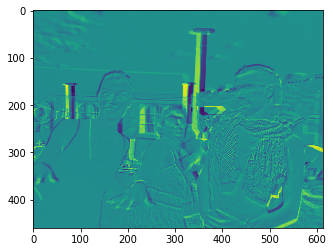

In [11]:
new_img1, new_img2 = shift(gray_imgs[0], gray_imgs[1], x=27, y=20)
pyplot.imshow(new_img1 - new_img2)

In [12]:
mean_pixel_diff(new_img1, new_img2)

15.98204837222498

That is certainly a smaller number! Let's minimize the mean pixel difference algorithmically

In [12]:
def align_images(shift_img, base_img):
    """Align images by searching for minimum pixel difference
    
    Returns the optimal x and y distance to shift images
    """
    x, y = 0, 0
    search_options = [
        (-20, 0), (0, -20), (20, 0), (0, 20),
        (-5, 0), (0, -5), (5, 0), (0, 5),
        (-1, 0), (0, -1), (1, 0), (0, 1),
    ]
    current_diff = mean_pixel_diff(*shift(shift_img, base_img, x, y))
    found_minimum = False
    while not found_minimum:
        for count, (dx, dy) in enumerate(search_options):
            shifted_imgs = shift(shift_img, base_img, x + dx, y + dy)
            new_diff = mean_pixel_diff(*shifted_imgs)
            if new_diff < current_diff:
                x += dx
                y += dy
                current_diff = new_diff
                break  # break the for-loop and start over
            if count == len(search_options) - 1:
                found_minimum = True
    return x, y

In [13]:
best_coordinates = align_images(gray_imgs[0], gray_imgs[1])
best_coordinates

(25, 23)

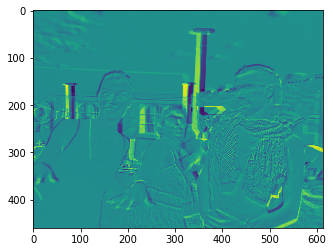

In [14]:
best_img1, best_img2 = shift(gray_imgs[0], gray_imgs[1], *best_coordinates)
pyplot.imshow(new_img1 - new_img2)

Not bad ;)

Let's align all the images..

In [15]:
relative_shift = [(0, 0)] + \
                 [align_images(gray_imgs[i], gray_imgs[i + 1]) for i in range(len(gray_imgs) - 1)]
relative_shift

[(0, 0), (25, 23), (-17, 17), (36, -26)]

In [16]:
shifts = np.array(relative_shift).cumsum(axis=0) * -1
shifts

array([[  0,   0],
       [-25, -23],
       [ -8, -40],
       [-44, -14]])

In [17]:
right_bottom = shifts - shifts.min(axis=0)
left_top = (shifts - shifts.max(axis=0)) * -1
crop_l_t_r_b = np.concatenate([left_top, right_bottom], axis=1)
crop_l_t_r_b

array([[ 0,  0, 44, 40],
       [25, 23, 19, 17],
       [ 8, 40, 36,  0],
       [44, 14,  0, 26]])

Final result:

In [18]:
imgs_cropped = [crop(img, *crop_size) for img, crop_size in zip(imgs, crop_l_t_r_b)]

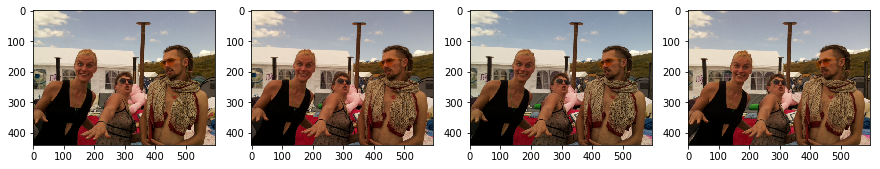

In [19]:
fig = pyplot.figure(figsize=(15, 5))
for i, img in enumerate(imgs_cropped):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(img)

### Color adjustment

Especially the two first images are colored differently. Here's a bit of the sky:

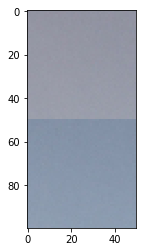

In [40]:
test_imgs = [
    imgs_cropped[1][:50,200:250,:],
    imgs_cropped[2][:50,200:250,:],
]
pyplot.imshow(np.concatenate(test_imgs))

Lets look at each color seperately and adjust the pixel intensities across images:

In [29]:
def normalize(arrays):
    total_mean = np.mean(arrays)
    adjusted = [(a + total_mean - a.mean()).astype(int) for a in arrays]
    return adjusted

# Smoke test
normalize(
    [np.array([1,2,3]),
     np.array([6,8,10])])

[array([4, 5, 6]), array([3, 5, 7])]

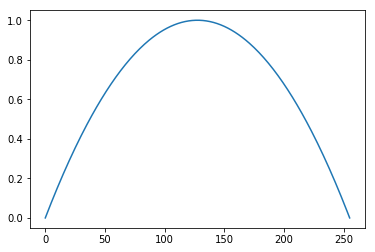

In [30]:
def curved_weights(array):
    """
    Compute a weight for each pixel, the weights are computed using this curve:
    https://www.wolframalpha.com/input/?i=y+%3D+1-+x%5E2+%2F(128*128)
    
    Which means that very light and very dark pixels will not change as much at the rest.
    """
    assert (0 <= array).all() and (array <= 255).all()  # all pixels must be 0-255
    result = array - 127.5  # center pixel values (from -128 to 128)
    result = 1 - result ** 2 / (127.5*127.5)
    assert (0 <= result).all() and (result <= 255).all()
    return result

# test add_curve
pyplot.plot(curved_weights(np.array(range(256))))  # curve

In [31]:
def normalize_with_curve(arrays):
    
    def mean(np_arr, min=100, max=155):
        """Find the mean of the pixels neither dark or bright"""
        return np.mean(np_arr[(np_arr >= min) & (np_arr <=max)])

    total_mean = mean(np.concatenate(arrays))
    res_arrays = []
    for a in arrays:
        res_arrays.append(a + (curved_weights(a) * 1 * (total_mean - mean(a))).astype(int))
    return res_arrays

# Smoke test
normalize_with_curve(
    [np.array([0,100,255]),
     np.array([0,150,255])])

[array([  0, 123, 255]), array([  0, 126, 255])]

In [101]:
def adjust_colors(imgs):
    """For each color, adjust the brightness towards the mean of all images"""
    split_in_colors = [(ch.squeeze() for ch in np.dsplit(img, 3)) for img in imgs]
    rs_gs_bs = zip(*split_in_colors)
    adjusted_rs_gs_bs = [normalize(chs) for chs in rs_gs_bs]
    adjusted_imgs = [np.dstack(rgb) for rgb in zip(*adjusted_rs_gs_bs)]
    return np.clip(adjusted_imgs, a_min=0, a_max=255).astype('uint8')

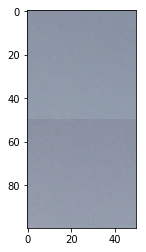

In [55]:
test_img_adjust = adjust_colors(test_imgs)
pyplot.imshow(np.concatenate(test_img_adjust))

In [76]:
import pandas as pd
img_adjusted = adjust_colors(imgs_cropped)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e6514e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e6a2ef0>]], dtype=object)

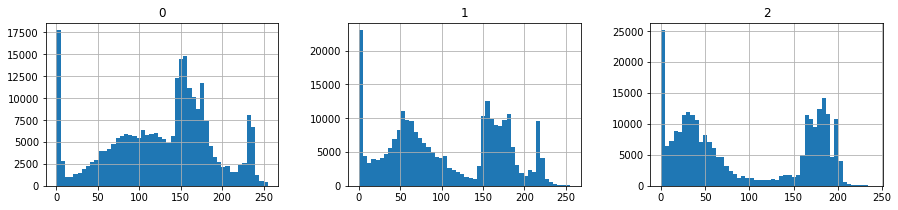

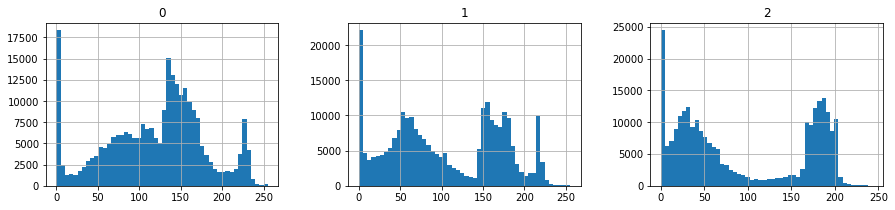

In [77]:
# Image 1 and 2 BEFORE color adjustment
pd.DataFrame(imgs_cropped[1].reshape(-1, 3)).hist(figsize=(15,3), bins=50, layout=(1, 3))
pd.DataFrame(imgs_cropped[2].reshape(-1, 3)).hist(figsize=(15,3), bins=50, layout=(1, 3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fa22828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11fa97278>]], dtype=object)

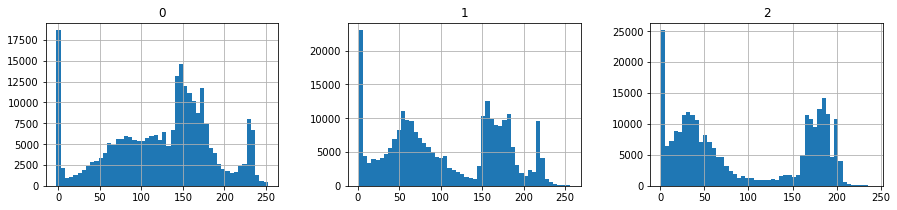

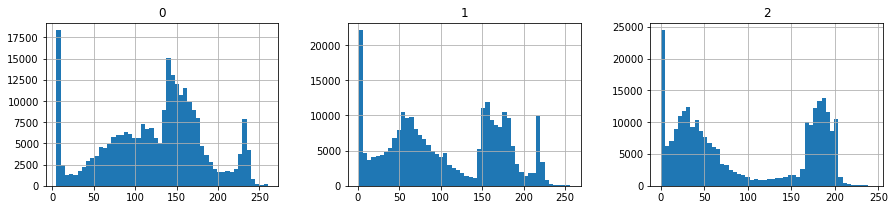

In [78]:
# Image 1 and 2 AFTER color adjustment
pd.DataFrame(img_adjusted[1].reshape(-1, 3)).hist(figsize=(15,3), bins=50, layout=(1, 3))
pd.DataFrame(img_adjusted[2].reshape(-1, 3)).hist(figsize=(15,3), bins=50, layout=(1, 3))

In [102]:
# # Make GIFs

# import glob
# import os

# all_images = glob.glob(dir_path + '*')
# all_images_base = list({os.path.basename(file_path)[:-2] for file_path in all_images})

# for image_base in all_images_base:
#     img_names = [image_base + '_' + str(i) for i in range(1, 5)]
#     imgs = [imageio.imread(dir_path + name) for name in img_names]
#     imgs_gray = [img.mean(axis=-1).astype(int) for img in imgs]
#     relative_shift = [(0, 0)] + \
#                      [align_images(imgs_gray[i], imgs_gray[i + 1]) for i in range(len(imgs_gray) - 1)]
#     shifts = np.array(relative_shift).cumsum(axis=0) * -1
#     right_bottom = shifts - shifts.min(axis=0)
#     left_top = (shifts - shifts.max(axis=0)) * -1
#     crop_l_t_r_b = np.concatenate([left_top, right_bottom], axis=1)
#     imgs_cropped = [crop(img, *crop_size) for img, crop_size in zip(imgs, crop_l_t_r_b)]
#     imgs_adjusted = adjust_colors(imgs_cropped)

#     imageio.mimwrite('/Users/elgehelge/Downloads/OUTPUT/auto_coloradjusted/' + image_base + '.gif',
#                      imgs_adjusted,
#                      fps=8)